## <center><ins>Trabajo Práctico 1: Reservas de hotel</ins></center>
#### <center>*Checkpoint 3: Ensambles - Stacking y Voting*</center>
##### <center>75.06 / 95.58 Organización de Datos - FIUBA</center>
##### <center>Ing. Rodríguez - 1°C 2023</center>
---
#### <center>**Grupo 31 - "Datazo":**</center>
<center> Michael Mena - 102685</center>
<center>Pablo Brocca - 104256</center>
<center>Diego Kisinovsky - 106203</center>

---
---

## Carga de datos y librerías

##### Imports:

In [15]:
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from IPython.display import Image

# Modelos y métricas
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, make_scorer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from six import StringIO

# Preprocesamiento
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Manejo de modelos
from pickle import dump
from pickle import load

# Configuración de warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#Emsables
from collections import defaultdict
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegressionCV
import plotly.graph_objects as go
%matplotlib inline

#Voting
from sklearn.ensemble import VotingClassifier

##### Lectura del dataset preprocesado:

In [16]:
hotel_train = pd.read_csv('./dataset/hotels_train_preprocesado.csv')

##### Importacion de modelos:

In [17]:
svm_norm = load(open('./modelos/model_svm_norm.pkl', 'rb'))
rf_cv = load(open('./modelos/model_randomforest_randomcv.pkl', 'rb'))
knn_cv = load(open('./modelos/model_knn_randomcv.pkl', 'rb'))
xgb_cv = load(open('./modelos/model_xgboost_randomcv.pkl', 'rb'))

##### Preparación de features:

In [18]:
features = hotel_train.drop(['is_canceled'],axis=1).columns
          
target = 'is_canceled'

features.tolist()

['lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_day_of_month',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'agent',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'stays_in_nights',
 'total_of_guests',
 'room_type_unchanged',
 'country_encoded',
 'customer_type_Group',
 'customer_type_Transient',
 'customer_type_Transient-Party',
 'deposit_type_Non Refund',
 'deposit_type_Refundable',
 'hotel_Resort Hotel',
 'distribution_channel_Direct',
 'distribution_channel_GDS',
 'distribution_channel_TA/TO',
 'distribution_channel_Undefined',
 'market_segment_Complementary',
 'market_segment_Corporate',
 'market_segment_Direct',
 'market_segment_Groups',
 'market_segment_Offline TA/TO',
 'market_segment_Online TA',
 'market_segment_Undefined',
 'meal_FB',
 'meal_HB',
 'meal_SC',
 'meal_Undefined']

---

## Armado y entrenamiento con Ensamble de Modelos

##### Preparación de features:

In [19]:
features = hotel_train.drop(['is_canceled'],axis=1).columns
          
target = 'is_canceled'

features.tolist()

['lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_day_of_month',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'agent',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'stays_in_nights',
 'total_of_guests',
 'room_type_unchanged',
 'country_encoded',
 'customer_type_Group',
 'customer_type_Transient',
 'customer_type_Transient-Party',
 'deposit_type_Non Refund',
 'deposit_type_Refundable',
 'hotel_Resort Hotel',
 'distribution_channel_Direct',
 'distribution_channel_GDS',
 'distribution_channel_TA/TO',
 'distribution_channel_Undefined',
 'market_segment_Complementary',
 'market_segment_Corporate',
 'market_segment_Direct',
 'market_segment_Groups',
 'market_segment_Offline TA/TO',
 'market_segment_Online TA',
 'market_segment_Undefined',
 'meal_FB',
 'meal_HB',
 'meal_SC',
 'meal_Undefined']

In [20]:
cols_categorical = ['room_type_unchanged',
                    'country_encoded',
                   'customer_type_Group',
                   'customer_type_Transient',
                   'customer_type_Transient-Party',
                   'deposit_type_Non Refund',
                   'deposit_type_Refundable',
                   'hotel_Resort Hotel',
                   'distribution_channel_Direct',
                   'distribution_channel_GDS',
                   'distribution_channel_TA/TO',
                   'distribution_channel_Undefined',
                   'market_segment_Complementary',
                   'market_segment_Corporate',
                   'market_segment_Direct',
                   'market_segment_Groups',
                   'market_segment_Offline TA/TO',
                   'market_segment_Online TA',
                   'market_segment_Undefined',
                   'meal_FB',
                   'meal_HB',
                   'meal_SC',
                   'meal_Undefined']

In [21]:
cols_to_normalize =[col for col in hotel_train.columns if col not in cols_categorical]

In [22]:
cols_to_normalize.remove('is_canceled')
cols_to_normalize

['lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_day_of_month',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'agent',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'stays_in_nights',
 'total_of_guests']

#### Definicion funciones:

In [23]:
#Funcion para evaluar los modelos 5fold -CV (repite 2 veces)
def evaluate_model(model, x, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
    scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, verbose=1, n_jobs=-1, error_score='raise')
    return scores

In [24]:
def bar_plot_results(model_scores, name):
    model_names = list(model_scores.keys())
    results = [model_scores[model] for model in model_names]
    means = [np.mean(result) for result in results]
    errors = [np.std(result) for result in results]
    fig = go.Figure()
    for model, mean, error in zip(model_names, means, errors):
        fig.add_trace(go.Bar(
            x=[model],
            y=[mean],
            name=model,
            error_y=dict(
                type='data',
                array=[error],
                visible=True,
                color='black',
                thickness=1,
                width=5
            )
        ))
    
    fig.update_layout(
        title='Score de Accuracy de cada modelo usando 5-Fold Cross-Validation',
        paper_bgcolor='rgb(243, 243, 243)',
        plot_bgcolor='rgb(243, 243, 243)',
        xaxis_title='Model',
        yaxis_title='Accuracy',
        showlegend=False
    )
    fig.show()

#### Train-Test Split:

In [25]:
# Separamos un 20% de los datos para test
x_train, x_test, y_train, y_test = train_test_split(hotel_train[features].values, 
                                                    hotel_train[target].values, 
                                                    test_size=0.2,    
                                                    random_state=42,  
                                                    stratify=hotel_train[target].values) 

# Verificamos cantidad de datos en cada set
print('# Datos Entrenamiento: {}'.format(len(x_train)))
print('# Datos Prueba: {}'.format(len(x_test)))

# Verificamos como quedaron balanceados
for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 48682
# Datos Prueba: 12171
% Positivos Entrenamiento: 50.433
% Positivos Prueba: 50.431


#### Normalización:
Versión estandarizada con $\frac{x_i - mean(x)}{stdev(x)}$

In [26]:
x_train_to_norm = pd.DataFrame(x_train, columns=features).drop(cols_categorical, axis=1)
x_test_to_norm = pd.DataFrame(x_test, columns=features).drop(cols_categorical, axis=1)

In [27]:
x_train_categorical = pd.DataFrame(x_train, columns=features).drop(cols_to_normalize, axis=1)
x_test_categorical = pd.DataFrame(x_test, columns=features).drop(cols_to_normalize, axis=1)

In [28]:
# Aplicar la transformación de escalado de características solo a las columnas seleccionadas
stand_scaler = StandardScaler()
x_train_norm_scaled = stand_scaler.fit_transform(x_train_to_norm)
x_test_norm_scaled = stand_scaler.transform(x_test_to_norm)

# Convertir las matrices escaladas nuevamente en DataFrames
x_train_norm_scaled = pd.DataFrame(x_train_norm_scaled, columns=cols_to_normalize)
x_test_norm_scaled = pd.DataFrame(x_test_norm_scaled, columns=cols_to_normalize)

# Agregar las columnas categoricas a las matrices escaladas
x_train_norm = pd.concat([x_train_norm_scaled, x_train_categorical], axis=1)
x_test_norm = pd.concat([x_test_norm_scaled, x_test_categorical], axis=1)

#### Entrenamiento y evaluación de modelos:
Se evaluarán los siguientes modelos:
- Random Forest
- SVM
- KNN
- XGBoost

Cada uno de los modelos se evaluará utilizando una estrategia de validación cruzada de cinco folds repetida dos veces. En cada iteracion cada modelo se entrenó en el 80 % de los datos y se validó en el 20 % restante.

Este método da como resultado 10 puntajes de performance diferentes para cada modelo que se almacenarán en un diccionario.

In [29]:
base_model = {'SVM': svm_norm, 'RF': rf_cv, 'KNN': knn_cv, 'XGB': xgb_cv}

#Guadamos los resultados de las métricas de cada modelo
model_scores = defaultdict()

#Entrenamos los clasificadores
for name, model in base_model.items():
    print('Entrenando modelo: {}'.format(name))
    scores = evaluate_model(model, x_train_norm, y_train)
    model_scores[name] = scores

Entrenando modelo: SVM


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Entrenando modelo: RF


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Entrenando modelo: KNN


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   37.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Entrenando modelo: XGB


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   16.0s finished


### Stacking

#### Armamos el emsamble con StackingCVClassifier, que utiliza como estimador final un LogisticRegression.

In [30]:
#Modelos bases
base_models = [('SVM', svm_norm), ('RF', rf_cv), ('KNN', knn_cv), ('XGB', xgb_cv)]

#Meta Modelo
meta_model = LogisticRegressionCV()

#Ensamble con stacking
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5, verbose=1, n_jobs=-1)

In [31]:
#Evaluo en conjunto de test
#stacking_model.fit(x_train,y_train).score(x_test,y_test)
stacking_model.fit(x_train_norm,y_train)
y_pred_st = stacking_model.predict(x_test_norm)
accuracy_score(y_test, y_pred_st)

0.8838222003122176

### Voting

In [32]:
#Creo ensemble de Votación
vot_clf = VotingClassifier(estimators=[('SVM', svm_norm), ('RF', rf_cv), ('KNN', knn_cv), ('XGB', xgb_cv)], voting='hard', n_jobs=-1)

#Entreno el ensamble
vot_clf.fit(x_train_norm, y_train)

#Evaluo el ensamble en el conjunto de test
y_pred_vot = vot_clf.predict(x_test_norm)
accuracy_score(y_test, y_pred_vot)

0.8697724098266371

---

## Análisis de los modelos Stacking y Voting

##### Algunas definiciones:

- **TP (True Positives):** Cantidad de clasificaciones positivas correctas

- **TN (True Negatives):** Cantidad de clasificaciones negativas correctas

- **FN (False Negatives):** Cantidad de clasificaciones negativas incorrectas

- **FP (False Positives):** Cantidad de clasificaciones positivas incorrectas


- **Precison = TP/TP+FP**\
    Porcentaje de valores clasificados como positivos que son realmente positivos

- **Recall/TPR (True Positive Rate) = TP/TP+FN**\
    Porcentaje de valores positivos que fueron correctamente clasificados

- **FPR (False Positive Rate) = FP/FP+TN**\
    Proporción de casos negativos clasificados como positivos

- **F1 Score = 2 * ( (precision * recall) / (precision + recall) )**\
    Métrica que combina precision y recall para un valor más objetivo

- **Support**\
    Cantidad de ocurrencias de cada clase en el split de test

#### Reporte de clasificación y matriz de confusión para Stacking:

              precision    recall  f1-score   support

           0       0.88      0.89      0.88      6033
           1       0.89      0.88      0.88      6138

    accuracy                           0.88     12171
   macro avg       0.88      0.88      0.88     12171
weighted avg       0.88      0.88      0.88     12171



Text(50.722222222222214, 0.5, 'True')

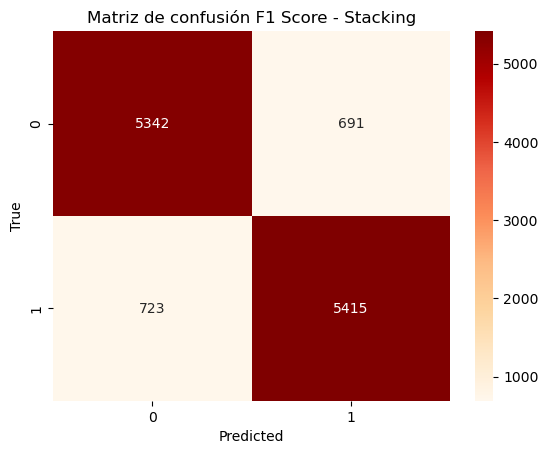

In [33]:
# Hacemos predicción sobre el set de evaluacion
y_pred = stacking_model.predict(x_test_norm)

# Reporte y Matriz de Confusion
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='OrRd',annot=True,fmt='g')
plt.title("Matriz de confusión F1 Score - Stacking")
plt.xlabel('Predicted')
plt.ylabel('True')

#### Reporte de clasificación y matriz de confusión para Voting:

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      6033
           1       0.90      0.84      0.87      6138

    accuracy                           0.87     12171
   macro avg       0.87      0.87      0.87     12171
weighted avg       0.87      0.87      0.87     12171



Text(50.722222222222214, 0.5, 'True')

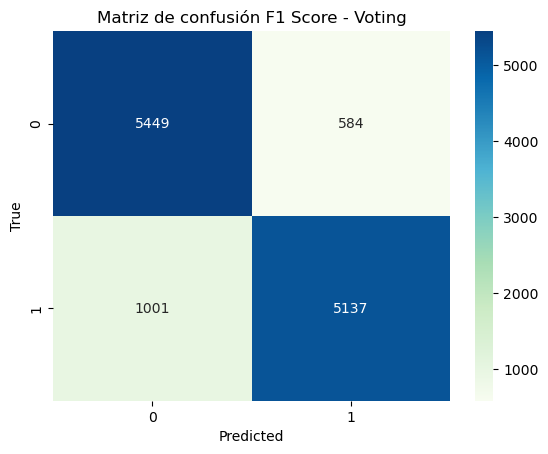

In [34]:
# Hacemos predicción sobre el set de evaluacion
y_pred = vot_clf.predict(x_test_norm)

# Reporte y Matriz de Confusion
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='GnBu',annot=True,fmt='g')
plt.title("Matriz de confusión F1 Score - Voting")
plt.xlabel('Predicted')
plt.ylabel('True')

#### Comparamos todos los modelos

In [35]:
# Evaluamos los scores de stacking
stacking_scores = evaluate_model(stacking_model, x_train_norm, y_train)
model_scores['stacking'] = stacking_scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 19.4min finished


In [36]:
print(stacking_scores)

[0.88363972 0.8811749  0.88753081 0.87808135 0.88660641 0.88292082
 0.88405053 0.8820871  0.88280608 0.88629827]


In [37]:
# Evaluamos los scores de voting
voting_scores = evaluate_model(vot_clf, x_train_norm, y_train)
model_scores['voting'] = voting_scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  4.3min finished


In [38]:
print(voting_scores)

[0.87049399 0.87675876 0.87561627 0.86832375 0.87931389 0.87408853
 0.87223991 0.87150781 0.87387017 0.87612983]


In [39]:
model_scores

defaultdict(None,
            {'SVM': array([0.84091609, 0.84225121, 0.84593262, 0.83709942, 0.85065735,
                    0.84009448, 0.8419431 , 0.84233772, 0.84315941, 0.84377568]),
             'RF': array([0.86587245, 0.86833727, 0.8759244 , 0.86668036, 0.87222679,
                    0.86494814, 0.86782377, 0.8661668 , 0.86811832, 0.86801561]),
             'KNN': array([0.84286741, 0.83567834, 0.84028348, 0.83011504, 0.84428924,
                    0.83660265, 0.8420458 , 0.83966721, 0.84161873, 0.8386401 ]),
             'XGB': array([0.8812776 , 0.88004519, 0.8874281 , 0.87859491, 0.88362777,
                    0.88240731, 0.88220191, 0.8830115 , 0.88270337, 0.88578472]),
             'stacking': array([0.88363972, 0.8811749 , 0.88753081, 0.87808135, 0.88660641,
                    0.88292082, 0.88405053, 0.8820871 , 0.88280608, 0.88629827]),
             'voting': array([0.87049399, 0.87675876, 0.87561627, 0.86832375, 0.87931389,
                    0.87408853, 0.87223991,

In [40]:
# Graficamos los resultados
bar_plot_results(model_scores, name='stacking_model_cv')

---

## Aplicación de modelos al dataset de test

##### Lectura del dataset de test preprocesado:

In [41]:
hotel_test = pd.read_csv('./dataset/hotels_test_preprocesado.csv')

##### Lectura del dataset de test original para mantener id:

In [42]:
hotel_test_df = pd.read_csv('./dataset/hotels_test.csv')

##### Predicción y exportación:

In [43]:
x_test_final = hotel_test[features]
x_test_final_cat = x_test_final[cols_categorical].copy()
x_test_final_cat.columns = cols_categorical

x_test_final_norm = pd.DataFrame(data=stand_scaler.transform(x_test_final[cols_to_normalize].copy()))
x_test_final_norm.columns = cols_to_normalize

x_test_final = pd.concat([x_test_final_norm, x_test_final_cat], axis=1)

In [44]:
y_pred_final_stacking = stacking_model.predict(x_test_final)

y_pred_final_voting = vot_clf.predict(x_test_final)

In [45]:
# TODO: asegurarse que y_pred_final tenga la forma correcta
y_pred_final_stacking

array([1, 1, 0, ..., 1, 1, 0], dtype=int64)

In [46]:
y_pred_final_voting

array([1, 1, 0, ..., 1, 1, 0], dtype=int64)

Una prediccion correcta deberia ser alrededor del 50% para cada clase, ya que el dataset de test esta balanceado.

In [47]:
counts = np.bincount(y_pred_final_stacking)
count_0 = counts[0]  # Cantidad de elementos 0
count_1 = counts[1]  # Cantidad de elementos 1

print("Resultado de la predicción STACKING: ")
print("No cancela:", count_0)
print("Cancela:", count_1)
print("Porceentaje de cancelaciones: {:.2f}%".format(count_1/(count_0+count_1)*100))

Resultado de la predicción STACKING: 
No cancela: 13199
Cancela: 13336
Porceentaje de cancelaciones: 50.26%


In [48]:
counts = np.bincount(y_pred_final_voting)
count_0 = counts[0]  # Cantidad de elementos 0
count_1 = counts[1]  # Cantidad de elementos 1

print("Resultado de la predicción VOTING: ")
print("No cancela:", count_0)
print("Cancela:", count_1)
print("Porceentaje de cancelaciones: {:.2f}%".format(count_1/(count_0+count_1)*100))

Resultado de la predicción VOTING: 
No cancela: 14004
Cancela: 12531
Porceentaje de cancelaciones: 47.22%


In [49]:
pd.concat([hotel_test_df['id'],pd.DataFrame(data=y_pred_final_stacking, columns=['is_canceled'])], axis=1).to_csv('./predicciones/pred_stacking.csv', index=False)

pd.concat([hotel_test_df['id'],pd.DataFrame(data=y_pred_final_voting, columns=['is_canceled'])], axis=1).to_csv('./predicciones/pred_voting.csv', index=False)

---

## Exportación de modelos

In [50]:
dump(stacking_model, open('./modelos/model_stacking.pkl', 'wb'))

dump(vot_clf, open('./modelos/model_voting.pkl', 'wb'))

---